## Clean_anonymize_basicplot_data

The goal of this notebook is to clean and anonymize a JSON file of lab queue data to be used for future analyses of the lab queue. We also generate some features that may be helpful in making preliminary predictions.

Author: Grace Guan (gg17)
Date: April 2020

In [1]:
import pandas as pd
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import time

In [2]:
df = pd.read_json("labqueue.json").dropna(how='any')

In [3]:
# toy example for datetime parsing

datetime_str = '2017-10-24T19:11'

datetime_object = datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M')
print(datetime_object) # printed in default format
assert(datetime_object.month == 10)
assert(datetime_object.year == 2017)
assert(datetime_object.day == 24)
assert(datetime_object.hour == 19)
assert(datetime_object.minute == 11) 

2017-10-24 19:11:00


In [4]:
def str_to_datetime(datetime_str):
    return datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M')

def str_to_datetime_for_csv(datetime_str):
    return datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')

df['time_accepted'] = df['time_accepted'].apply(str_to_datetime)
df['time_closed'] = df['time_closed'].apply(str_to_datetime)
df['time_created'] = df['time_created'].apply(str_to_datetime)

In [5]:
df['wait_time'] = df['time_accepted'] - df['time_created']
df['help_time'] = df['time_closed'] - df['time_accepted']

In [6]:
df['TA_anon'] = df.groupby(['accepted_by']).ngroup()
df['student_anon'] = df.groupby(['author']).ngroup()

In [7]:
def get_year(datetime_obj):
    return datetime_obj.year

def get_month(datetime_obj):
    return datetime_obj.month

def get_day(datetime_obj):
    return datetime_obj.day

def get_hour(datetime_obj):
    return datetime_obj.hour

def get_minute(datetime_obj):
    return datetime_obj.minute

def get_dayofweek(datetime_obj):
    return datetime_obj.weekday()

def get_weekofyear(datetime_obj):
    return datetime_obj.isocalendar()[1]

df['year'] = df['time_accepted'].apply(get_year)
df['month'] = df['time_accepted'].apply(get_month)
df['day'] = df['time_accepted'].apply(get_day)
df['day_created'] = df['time_created'].apply(get_day)
df['hour_accepted'] = df['time_accepted'].apply(get_hour)
df['minute_accepted'] = df['time_accepted'].apply(get_minute)
df['hour_created'] = df['time_created'].apply(get_hour)
df['minute_created'] = df['time_created'].apply(get_minute)
df['hour_closed'] = df['time_closed'].apply(get_hour)
df['minute_closed'] = df['time_closed'].apply(get_minute)
df['day_of_week'] = df['time_created'].apply(get_dayofweek) #Monday is 0 and Sunday is 6
df['week_of_year'] = df['time_created'].apply(get_weekofyear)

df.shape

(16784, 28)

In [8]:
# Drop any entry that was created on one day and deleted the next day
df.drop(df[df['day_created'] != df['day']].index, inplace = True) 
df.shape

(16763, 28)

In [9]:
# Drop lab queue testing entries created by Maia
df.drop(df[df['author'] == 'maia'].index, inplace = True) 
df.shape

(16760, 28)

In [10]:
def time_delta_to_min(timedelta_obj):
    return timedelta_obj.seconds / 60

df['wait_time_in_minutes'] = df['wait_time'].apply(time_delta_to_min)
df['help_time_in_minutes'] = df['help_time'].apply(time_delta_to_min)
df['help_time_in_minutes'] = np.clip(df['help_time_in_minutes'], a_max = 100, a_min = None)

In [11]:
# Drop any extreme outliers (these are all covered by the cases
# above, but just to be safe)
df.drop(df[df['wait_time_in_minutes'] > 600].index, inplace = True) 
df.shape

(16758, 30)

In [12]:
# Plot different colors by day of week
# Monday is 0 and Sunday is 6
categories = [0, 1, 2, 3, 4, 5, 6]
colors = ["red", "chocolate", "gold", "green", "cyan", "blue", "m"]
colordict = dict(zip(categories, colors))  

df["Color"] = df["day_of_week"].apply(lambda x: colordict[x])

classes = ["cos109", "cos126", "cos226", "cos217"]
markers = ["d", ".", "+", "x"]
classdict = dict(zip(classes, markers))  

df["Marker"] = df["course"].apply(lambda x: classdict[x])

In [13]:
# Remove people's names and save the CSV

df = df.drop(columns=['accepted_by', 'author', 'author_full_name', 'closed_by'])

In [14]:
df = df.join(pd.get_dummies(df['course']))

In [15]:
dayofweeks = pd.get_dummies(df['day_of_week'])
dayofweeks.columns = ['isMonday', 'isTuesday', 'isWednesday',
                      'isThursday', 'isFriday', 'isSaturday', 'isSunday']
df = df.join(dayofweeks)

In [16]:
weeksofyear = pd.get_dummies(df['week_of_year'])
weeksofyear.columns = ['woy2','woy3','woy6','woy7','woy8','woy9','woy10',
                      'woy11','woy12','woy13','woy14','woy15','woy16',
                      'woy17','woy18','woy19','woy20','woy37','woy38',
                      'woy39','woy40','woy41','woy42','woy43','woy44',
                      'woy45','woy46','woy47','woy48','woy49','woy50']
df = df.join(weeksofyear)

In [17]:
df.to_csv("labqueue_anon.csv")

In [18]:
def preprocess_dates_in_csv(df):
    df.index = df["Unnamed: 0"]
    df['time_accepted'] = df['time_accepted'].apply(str_to_datetime_for_csv)
    df['time_closed'] = df['time_closed'].apply(str_to_datetime_for_csv)
    df['time_created'] = df['time_created'].apply(str_to_datetime_for_csv)
    df['wait_time'] = df['time_accepted'] - df['time_created']
    df['year'] = df['time_accepted'].apply(get_year)
    df['month'] = df['time_accepted'].apply(get_month)
    df['day'] = df['time_accepted'].apply(get_day)
    df['day_created'] = df['time_created'].apply(get_day)
    df['hour_accepted'] = df['time_accepted'].apply(get_hour)
    df['minute_accepted'] = df['time_accepted'].apply(get_minute)
    df['hour_created'] = df['time_created'].apply(get_hour)
    df['minute_created'] = df['time_created'].apply(get_minute)
    df['hour_closed'] = df['time_closed'].apply(get_hour)
    df['minute_closed'] = df['time_closed'].apply(get_minute)
    df['day_of_week'] = df['time_created'].apply(get_dayofweek) #Monday is 0 and Sunday is 6
    df['week_of_year'] = df['time_created'].apply(get_weekofyear)
    df['wait_time_in_minutes'] = df['wait_time'].apply(time_delta_to_min)
    return df

In [19]:
df.shape

(16758, 70)

## Quickly plot the wait times of each individual student in the dataframe

These plots don't mean much as the x-axis doesn't correspond to any linear timeframe. These graphs help us see the volume of each day as well as the wait times for each day. We separate data points by weekday (color) and by class (shape).

In [20]:
df = preprocess_dates_in_csv(pd.read_csv("labqueue_anon.csv"))

In [21]:
def plot_wait_times(df, start_idx, end_idx):
    fig, ax = plt.subplots(figsize=(15,6))
    classes = ["cos109", "cos126", "cos226", "cos217"]
    for course in classes:
        plotdf = df.where(df["course"] == course).dropna(how='all')
        plt.scatter(plotdf.loc[start_idx:end_idx].index,
                    plotdf["wait_time_in_minutes"].loc[start_idx:end_idx],
                    marker=classdict[course],
                    color=plotdf.Color.loc[start_idx:end_idx],
                    label='Wait Times')

    legend_elements = [Line2D([0], [0], marker='.', color='red', label='Mon'),
                       Line2D([0], [0], marker='.', color='chocolate', label='Tues'),
                       Line2D([0], [0], marker='.', color='gold', label='Weds'),
                       Line2D([0], [0], marker='.', color='green', label='Thurs'),
                       Line2D([0], [0], marker='.', color='c', label='Fri'),
                       Line2D([0], [0], marker='.', color='b', label='Sat'),
                       Line2D([0], [0], marker='.', color='m', label='Sun'),
                       Line2D([0], [0], marker='d', color='black', label='COS 109'),
                       Line2D([0], [0], marker='.', color='black', label='COS 126'),
                       Line2D([0], [0], marker='+', color='black', label='COS 226'),
                       Line2D([0], [0], marker='x', color='black', label='COS 217')]
    ax.legend(handles=legend_elements)

    plt.xlabel("Index in dataframe (time is not linear!)")
    plt.ylabel("Wait Times of each student indexed in the dataframe")
    plt.title("Temp Graph (elements %d to %d of dataframe)" % (start_idx, end_idx))
    plt.show()

This is a typical span of two weeks for the lab queue. The spike in red is the Monday that WordNet was due for COS 226, and Guitar hero was due for COS 126 in Fall 2017. This is confirmed by the presence of lots of plus marks (representing COS 226) and dots (representing COS 126). Generally, wait times remain under 40 minutes.

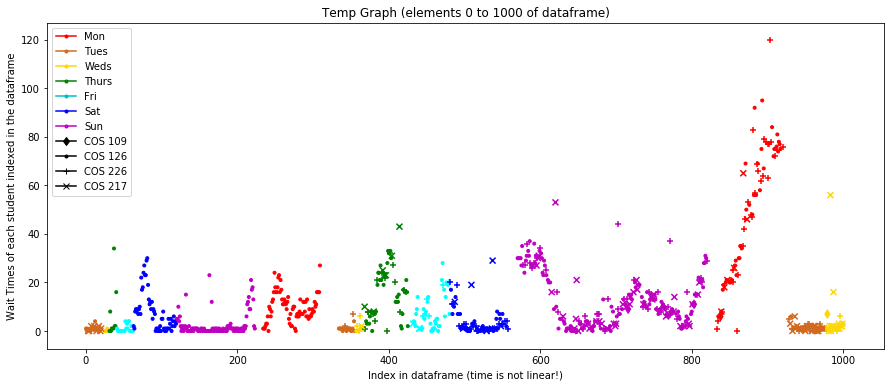

In [22]:
start_idx = 0
end_idx = 1000

plot_wait_times(df, start_idx, end_idx)

This graph represents January 2018, specifically the week leading up to Dean's Date for the Fall 2017 semester. The orange, yellow, and green on the righthand side represent the first three day sof the spring semester. For all shifts in the week leading up to Dean's Date, wait times are low at the beginning of each shift and then quickly spike. Additionally, most requests appear to be coming from COS 217. This makes sense because the COS 217 final project is very difficult compared to the COS 126 and 226 final projects.  It's also interesting that there are clusters of dots below the clusters of x's, especially for the Sunday before Dean's Date and Dean's Date itself. This indicates that TAs are taking COS 126 students off the queue before they address 217 students on the queue.

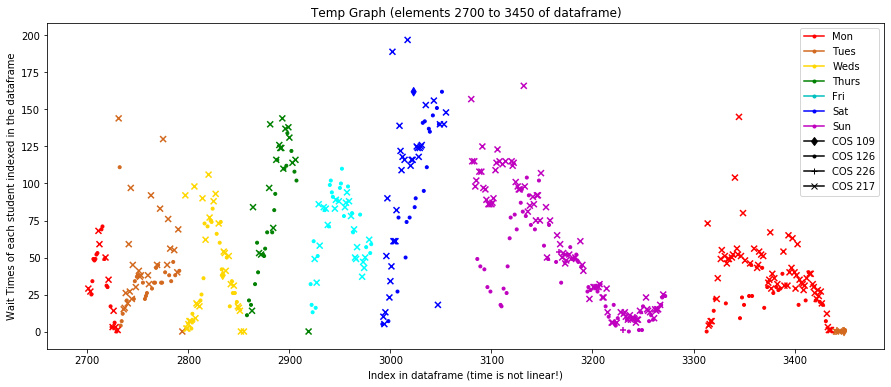

In [23]:
start_idx = 2700
end_idx = 3450

plot_wait_times(df, start_idx, end_idx)

Plot some stuff from the end of our dataframe, just for fun.

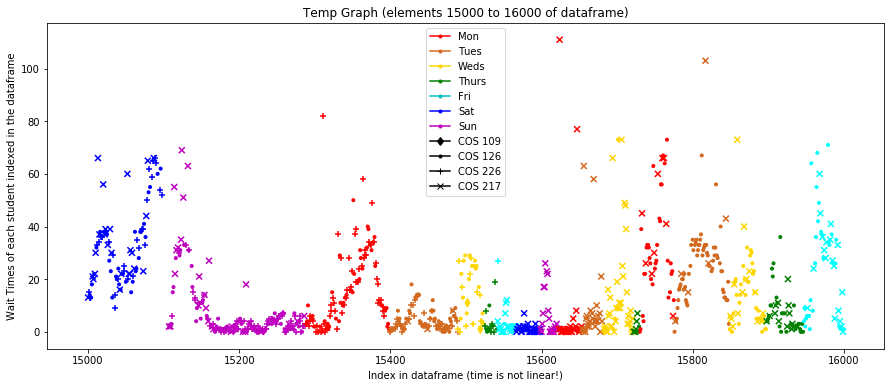

In [24]:
start_idx = 15000
end_idx = 16000

plot_wait_times(df, start_idx, end_idx)

## Make time linear again!

Now, we make time linear again by plotting the average wait time for each 10-minute interval. 

In [25]:
df2 = preprocess_dates_in_csv(pd.read_csv("labqueue_anon.csv"))

In [26]:
df2.index = df2["time_created"]

In [27]:
resampled_df = df2.resample('10T', level=0).mean()

We take a look at a sample "peak" day. Note that November 13, 2017 was the day that WordNet was due for COS 226 and GuitarHero was due for COS 126.

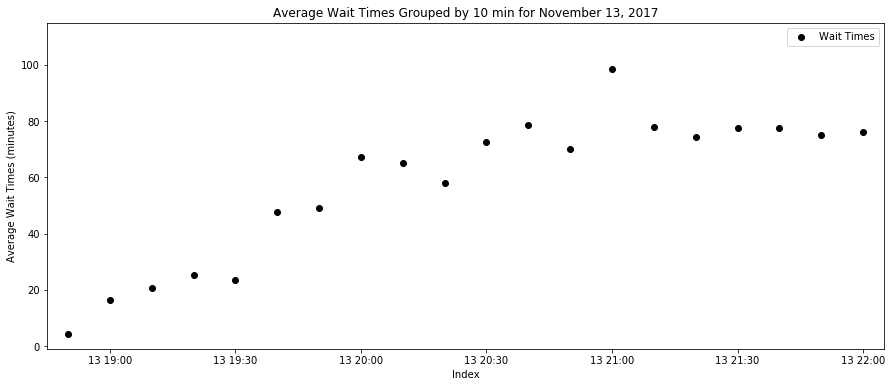

In [28]:
fig, ax = plt.subplots(figsize=(15,6))
plt.scatter(resampled_df.index, resampled_df["wait_time_in_minutes"], marker='o', color='black', label='Wait Times')
plt.legend(loc=1)
plt.xlim((pd.Timestamp("2017-11-13 18:45:00"), pd.Timestamp("2017-11-13 22:05:00")))
plt.ylim(-1, 115)
plt.xlabel("Index")
plt.ylabel("Average Wait Times (minutes)")
plt.title("Average Wait Times Grouped by 10 min for November 13, 2017")
plt.show()

Do the same thing for a random other day. (The same day, one year later, was after WordNet and Guitar Hero were due).

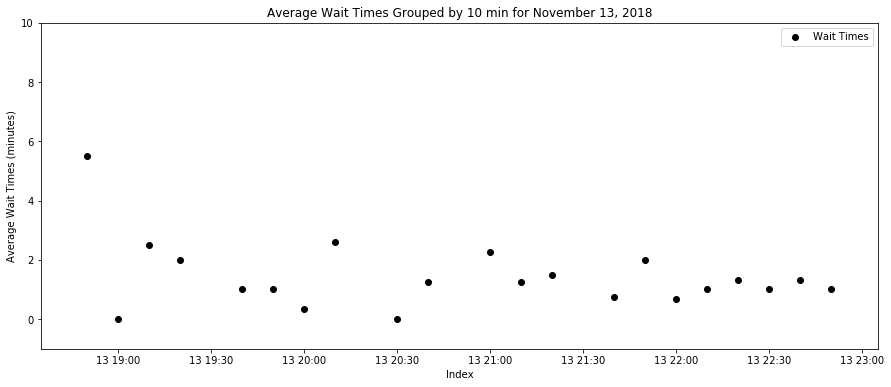

In [29]:
fig, ax = plt.subplots(figsize=(15,6))
plt.scatter(resampled_df.index, resampled_df["wait_time_in_minutes"], marker='o', color='black', label='Wait Times')
plt.legend(loc=1)
plt.xlim((pd.Timestamp("2018-11-13 18:35:00"), pd.Timestamp("2018-11-13 23:05:00")))
plt.ylim(-1, 10)
plt.xlabel("Index")
plt.ylabel("Average Wait Times (minutes)")
plt.title("Average Wait Times Grouped by 10 min for November 13, 2018")
plt.show()

# Adjusting the wait time feature so that we take back-parse out the following:

We need to create a new metric for the t_x wait time feature, which includes parsing the following from the data:
- average wait time of requests completed before this request was submitted,
- average help time of requests completed before this request was submitted,
- number of people before them in the queue


In [30]:
df = preprocess_dates_in_csv(pd.read_csv("labqueue_anon.csv"))

In [31]:
average_wait_30min_before_us = list()
average_help_30min_before_us = list()
average_wait_90min_before_us = list()
average_help_90min_before_us = list()
num_in_queue_before_us = list()

start = time.time()
for i, row in df.iterrows():
    our_creation = row["time_created"]
    our_creation_minus90 = our_creation - dt.timedelta(hours=1.5)
    our_creation_minus30 = our_creation - dt.timedelta(hours=0.5)

    w90minbeforeus = df.loc[(df["time_accepted"] > our_creation_minus90) & (df["time_accepted"] < our_creation)]
    w30minbeforeus = df.loc[(df["time_accepted"] > our_creation_minus30) & (df["time_accepted"] < our_creation)]
    h90minbeforeus = df.loc[(df["time_closed"] > our_creation_minus90) & (df["time_closed"] < our_creation)]
    h30minbeforeus = df.loc[(df["time_closed"] > our_creation_minus30) & (df["time_closed"] < our_creation)]
    inqueuebeforeus = df.loc[(df["time_created"] < our_creation) & (df["time_closed"] > our_creation)]
    average_wait_30min_before_us.append(w30minbeforeus["wait_time_in_minutes"].mean())
    average_help_30min_before_us.append(h30minbeforeus["help_time_in_minutes"].mean())
    average_wait_90min_before_us.append(w90minbeforeus["wait_time_in_minutes"].mean())
    average_help_90min_before_us.append(h90minbeforeus["help_time_in_minutes"].mean())
    num_in_queue_before_us.append(len(inqueuebeforeus))
    
    if i % 1000 == 0:
        now = time.time()
        print("%d iterations completed in %.3f s" % (i, now - start))

0 iterations completed in 0.591 s
1000 iterations completed in 7.367 s
2000 iterations completed in 13.753 s
3000 iterations completed in 20.196 s
4000 iterations completed in 27.237 s
5000 iterations completed in 34.120 s
6000 iterations completed in 40.460 s
7000 iterations completed in 47.908 s
8000 iterations completed in 56.026 s
9000 iterations completed in 63.474 s
10000 iterations completed in 70.839 s
12000 iterations completed in 84.572 s
13000 iterations completed in 91.344 s
14000 iterations completed in 98.839 s
15000 iterations completed in 106.071 s
16000 iterations completed in 114.204 s
18000 iterations completed in 129.528 s
19000 iterations completed in 136.693 s


In [32]:
df['wait_time_90m_before_submit'] = average_wait_90min_before_us
df['wait_time_30m_before_submit'] = average_wait_30min_before_us
df['help_time_90m_before_submit'] = average_help_90min_before_us
df['help_time_30m_before_submit'] = average_help_30min_before_us
df['num_in_queue_before_us'] = num_in_queue_before_us

In [33]:
df['wait_time_90m_before_submit'].fillna(0, inplace=True)
df['wait_time_30m_before_submit'].fillna(0, inplace=True)
df['help_time_90m_before_submit'].fillna(0, inplace=True)
df['help_time_30m_before_submit'].fillna(0, inplace=True)
df['num_in_queue_before_us'].fillna(0, inplace=True)

In [34]:
df["time_created_floor"] = [x.floor("60min") for x in df["time_created"]]

In [35]:
TAs_per_hour_map = df.groupby("time_created_floor")["TA_anon"].nunique().to_dict()

In [36]:
df["TAs_this_hour"] = df["time_created_floor"].replace(TAs_per_hour_map)

# Add feature for whether or not an assignment is due today or the next day

In [37]:
due_126 = [dt.datetime(2017, 9, 18), dt.datetime(2017, 9, 25),
          dt.datetime(2017, 10, 2), dt.datetime(2017, 10, 9),
          dt.datetime(2017, 10, 23), dt.datetime(2017, 11, 6),
          dt.datetime(2017, 11, 13), dt.datetime(2017, 11, 27),
          dt.datetime(2017, 12, 4), dt.datetime(2018, 1, 16),
          dt.datetime(2018, 2, 12), dt.datetime(2018, 2, 19),
          dt.datetime(2018, 2, 26), dt.datetime(2018, 3, 5),
          dt.datetime(2018, 3, 26), dt.datetime(2018, 4, 2),
          dt.datetime(2018, 4, 9), dt.datetime(2018, 4, 16),
          dt.datetime(2018, 4, 23), dt.datetime(2018, 5, 15),
          dt.datetime(2018, 9, 17), dt.datetime(2018, 9, 24),
          dt.datetime(2018, 10, 1), dt.datetime(2018, 10, 8),
          dt.datetime(2018, 10, 22), dt.datetime(2018, 11, 5),
          dt.datetime(2018, 11, 12), dt.datetime(2018, 11, 26),
          dt.datetime(2018, 12, 3), dt.datetime(2019, 1, 15),
          dt.datetime(2019, 2, 11), dt.datetime(2019, 2, 18),
          dt.datetime(2019, 2, 25), dt.datetime(2019, 3, 4),
          dt.datetime(2019, 3, 25), dt.datetime(2019, 4, 1),
          dt.datetime(2019, 4, 8), dt.datetime(2019, 4, 15),
          dt.datetime(2019, 4, 22), dt.datetime(2019, 5, 14),
          dt.datetime(2019, 9, 16), dt.datetime(2019, 9, 23),
          dt.datetime(2019, 9, 30), dt.datetime(2019, 10, 7),
          dt.datetime(2019, 10, 21), dt.datetime(2019, 11, 4),
          dt.datetime(2019, 11, 11), dt.datetime(2019, 11, 18),
          dt.datetime(2019, 12, 2), dt.datetime(2020, 1, 14)]
day_of_126 = [x.date() for x in due_126]
day_before_126 = [(x - pd.DateOffset(days=1)).date() for x in due_126]

due_226 = [dt.datetime(2017, 9, 18), dt.datetime(2017, 9, 25),
          dt.datetime(2017, 10, 2), dt.datetime(2017, 10, 9),
          dt.datetime(2017, 10, 16), dt.datetime(2017, 11, 13),
          dt.datetime(2017, 11, 20), dt.datetime(2017, 12, 4), 
          dt.datetime(2018, 2, 12), dt.datetime(2018, 2, 19),
          dt.datetime(2018, 2, 26), dt.datetime(2018, 3, 5),
          dt.datetime(2018, 4, 2), dt.datetime(2018, 4, 9),
          dt.datetime(2018, 4, 16), dt.datetime(2018, 5, 14),
          dt.datetime(2018, 9, 17), dt.datetime(2018, 9, 24),
          dt.datetime(2018, 10, 1), dt.datetime(2018, 10, 8),
          dt.datetime(2018, 10, 15), dt.datetime(2018, 11, 12),
          dt.datetime(2018, 11, 19), dt.datetime(2018, 12, 3), 
          dt.datetime(2019, 2, 11), dt.datetime(2019, 2, 18),
          dt.datetime(2019, 2, 25), dt.datetime(2019, 3, 4),
          dt.datetime(2019, 4, 1), dt.datetime(2019, 4, 8),
          dt.datetime(2019, 4, 15), dt.datetime(2019, 4, 29),
          dt.datetime(2019, 9, 16), dt.datetime(2019, 9, 23),
          dt.datetime(2019, 9, 30), dt.datetime(2019, 10, 7),
          dt.datetime(2019, 10, 14), dt.datetime(2019, 11, 11),
          dt.datetime(2019, 11, 18), dt.datetime(2019, 12, 9)]
day_of_226 = [x.date() for x in due_226]
day_before_226 = [(x - pd.DateOffset(days=1)).date() for x in due_226]

due_217 = [dt.datetime(2017, 9, 24), dt.datetime(2017, 10, 1),
          dt.datetime(2017, 10, 10), dt.datetime(2017, 10, 22),
          dt.datetime(2017, 11, 21), dt.datetime(2017, 12, 3),
          dt.datetime(2017, 12, 13), dt.datetime(2018, 1, 16), 
          dt.datetime(2018, 2, 11), dt.datetime(2018, 2, 18),
          dt.datetime(2018, 2, 28), dt.datetime(2018, 3, 11),
          dt.datetime(2018, 4, 11), dt.datetime(2018, 4, 22),
          dt.datetime(2018, 5, 2), dt.datetime(2018, 5, 15),
          dt.datetime(2018, 9, 23), dt.datetime(2018, 9, 30),
          dt.datetime(2018, 10, 9), dt.datetime(2018, 10, 21),
          dt.datetime(2018, 11, 20), dt.datetime(2018, 12, 2),
          dt.datetime(2018, 12, 13), dt.datetime(2019, 1, 15), 
          dt.datetime(2019, 2, 10), dt.datetime(2019, 2, 17),
          dt.datetime(2019, 2, 26), dt.datetime(2019, 3, 10),
          dt.datetime(2019, 4, 9), dt.datetime(2019, 4, 23),
          dt.datetime(2019, 5, 3), dt.datetime(2019, 5, 14),
          dt.datetime(2019, 9, 22), dt.datetime(2019, 9, 29),
          dt.datetime(2019, 10, 8), dt.datetime(2019, 10, 20),
          dt.datetime(2019, 11, 19), dt.datetime(2019, 12, 3),
          dt.datetime(2019, 12, 12), dt.datetime(2020, 1, 14)]
day_of_217 = [x.date() for x in due_217]
day_before_217 = [(x - pd.DateOffset(days=1)).date() for x in due_217]

In [38]:
def find_day_before_217(this_day):
    if this_day.date() in day_before_217:
        return 1
    return 0

def find_day_of_217(this_day):
    if this_day.date() in day_of_217:
        return 1
    return 0

def find_day_before_226(this_day):
    if this_day.date() in day_before_226:
        return 1
    return 0

def find_day_of_226(this_day):
    if this_day.date() in day_of_226:
        return 1
    return 0

def find_day_before_126(this_day):
    if this_day.date() in day_before_126:
        return 1
    return 0

def find_day_of_126(this_day):
    if this_day.date() in day_of_126:
        return 1
    return 0

In [39]:
df['day_before_217_due'] = df['time_accepted'].apply(find_day_before_217)
df['day_of_217_due'] = df['time_accepted'].apply(find_day_of_217)
df['day_before_226_due'] = df['time_accepted'].apply(find_day_before_226)
df['day_of_226_due'] = df['time_accepted'].apply(find_day_of_226)
df['day_before_126_due'] = df['time_accepted'].apply(find_day_before_126)
df['day_of_126_due'] = df['time_accepted'].apply(find_day_of_126)

In [40]:
def daybefore(course, due217, due226, due126):
    if course == "cos126" and due126 == 1:
        return 1
    elif course == "cos226" and due226 == 1:
        return 1
    elif course == "cos217" and due217 == 1:
        return 1
    else:
        return 0

df['assignment_due_next_day'] = np.vectorize(daybefore)(df['course'], df['day_before_217_due'],
                                                 df['day_before_226_due'], df['day_before_126_due'])

In [41]:
def dayof(course, due217, due226, due126):
    if course == "cos126" and due126 == 1:
        return 1
    elif course == "cos226" and due226 == 1:
        return 1
    elif course == "cos217" and due217 == 1:
        return 1
    else:
        return 0

df['assignment_due_day_of'] = np.vectorize(dayof)(df['course'], df['day_of_217_due'],
                                                 df['day_of_226_due'], df['day_of_126_due'])

In [42]:
def taq(tas, q_length):
    if tas >= q_length:
        return 1
    else:
        return 0

df['more_TAs_than_queue'] = np.vectorize(taq)(df['TAs_this_hour'], df['num_in_queue_before_us'])

In [44]:
df["sem_week_1"] = df[['woy37','woy38','woy6']].max(axis=1)
df["sem_week_2"] = df[['woy39','woy7']].max(axis=1)
df["sem_week_3"] = df[['woy40','woy8']].max(axis=1)
df["sem_week_4"] = df[['woy41','woy9']].max(axis=1)
df["sem_week_5"] = df[['woy42','woy10']].max(axis=1)
df["sem_week_6"] = df[['woy43','woy11']].max(axis=1)
df["sem_week_fallspringbreak"] = df[['woy44','woy12']].max(axis=1)
df["sem_week_7"] = df[['woy45','woy13']].max(axis=1)
df["sem_week_8"] = df[['woy46','woy14']].max(axis=1)
df["sem_week_9"] = df[['woy47','woy15']].max(axis=1)
df["sem_week_10"] = df[['woy48','woy16']].max(axis=1)
df["sem_week_11"] = df[['woy49','woy17']].max(axis=1)
df["sem_week_12"] = df[['woy50','woy18']].max(axis=1)
df["sem_week_13"] = df[['woy2','woy19']].max(axis=1)
df["sem_week_14"] = df[['woy3','woy20']].max(axis=1)

In [45]:
df.to_csv("labqueue_anon.csv")